In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.ops import math_ops
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')
import json
import ast
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from tensorflow.keras.layers import Embedding, Conv2D, MaxPooling2D, Dropout, Reshape, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/My Drive/movies_metadata.csv')
df.head()

<ipython-input-2-3d7d8ecd1a33>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
#Keep the columns we want to evaluate
columns_to_keep = ['title', 'id', 'imdb_id', 'genres', 'release_date', 'original_language', 'vote_average', 'vote_count', 'tagline']
movie_df = df[columns_to_keep]
#Drop rows where 'id' is NaN
movie_df = movie_df.dropna(subset=['id'])

movie_df['id'] = movie_df['id'].astype(str)
# Drop rows where 'id' contains a hyphen '-'
movie_df = movie_df[~movie_df['id'].str.contains('-')]
movie_df.head()

,title,id,imdb_id,genres,release_date,original_language,vote_average,vote_count,tagline
0,Toy Story,862,tt0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,en,7.7,5415.0,NaN
1,Jumanji,8844,tt0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,en,6.9,2413.0,Roll the dice and unleash the excitement!
2,Grumpier Old Men,15602,tt0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,en,6.5,92.0,Still Yelling. Still Fighting. Still Ready for...
3,Waiting to Exhale,31357,tt0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,en,6.1,34.0,Friends are the people who let you be yourself...
4,Father of the Bride Part II,11862,tt0113041,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,en,5.7,173.0,Just When His World Is Back To Normal... He's ...


In [4]:
#The genres are messy, so we have to clean the data. we want to convert the genres to integers and then list.
#Actually we could use one hot encoding as well. but the dimension will be to large when we process tagline and titles.
movie_df = movie_df.copy()

# Extract Genre IDs
def extract_genre_ids(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['id'] for genre in genres_list]
    except:
        return []

movie_df['genre_ids'] = movie_df['genres'].apply(extract_genre_ids)

# Create a Mapping from Genre IDs to Integers
genre_ids = set(g for sublist in movie_df['genre_ids'] for g in sublist)
genres2int = {genre_id: ii for ii, genre_id in enumerate(genre_ids, start=1)}  # Start from 1
genres2int['<PAD>'] = 0  # Use 0 for padding

# Convert Genre IDs to Integer Lists
movie_df['genres_int'] = movie_df['genre_ids'].apply(lambda ids: [genres2int[id] for id in ids])

# Pad the Genre Lists
max_len = max(movie_df['genres_int'].apply(len))
movie_df['genres_int'] = movie_df['genres_int'].apply(lambda ids: ids + [genres2int['<PAD>']] * (max_len - len(ids)))

In [5]:
movie_df.head()

,title,id,imdb_id,genres,release_date,original_language,vote_average,vote_count,tagline,genre_ids,genres_int
0,Toy Story,862,tt0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,en,7.7,5415.0,NaN,"[16, 35, 10751]","[4, 11, 20, 0, 0, 0, 0, 0]"
1,Jumanji,8844,tt0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,en,6.9,2413.0,Roll the dice and unleash the excitement!,"[12, 14, 10751]","[2, 3, 20, 0, 0, 0, 0, 0]"
2,Grumpier Old Men,15602,tt0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,en,6.5,92.0,Still Yelling. Still Fighting. Still Ready for...,"[10749, 35]","[19, 11, 0, 0, 0, 0, 0, 0]"
3,Waiting to Exhale,31357,tt0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,en,6.1,34.0,Friends are the people who let you be yourself...,"[35, 18, 10749]","[11, 6, 19, 0, 0, 0, 0, 0]"
4,Father of the Bride Part II,11862,tt0113041,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,en,5.7,173.0,Just When His World Is Back To Normal... He's ...,[35],"[11, 0, 0, 0, 0, 0, 0, 0]"


In [6]:
# Create a mapping for movie_id to a suitable range
unique_movie_ids = sorted(set(movie_df['id']))
movie_id_to_index = {id_: idx for idx, id_ in enumerate(unique_movie_ids)}

# Apply the mapping
movie_df['movie_id_index'] = movie_df['id'].map(movie_id_to_index)

In [7]:
#Then we want to map title to title sequence
#In case there is NaN values
movie_df['title'] = movie_df['title'].fillna('')
#Create a Set of Unique Words from Titles
title_set = set()
for title in movie_df['title'].str.split():
    title_set.update(title)

#Add a padding token
title_set.add('<PAD>')

#Create a Mapping from Words to Integers
title2int = {word: i for i, word in enumerate(title_set)}

#Convert Titles to Lists of Integers
def title_to_int_sequence(title):
    return [title2int.get(word, title2int['<PAD>']) for word in title.split()]

# Apply the function to the 'Title' column
movie_df['title'] = movie_df['title'].apply(title_to_int_sequence)

#Pad the Title Sequences
title_count = 10
movie_df['title'] = movie_df['title'].apply(lambda x: x + [title2int['<PAD>']] * (title_count - len(x)) if len(x) < title_count else x[:title_count])


In [8]:
movie_df.head()

,title,id,imdb_id,genres,release_date,original_language,vote_average,vote_count,tagline,genre_ids,genres_int,movie_id_index
0,"[24422, 6448, 17152, 17152, 17152, 17152, 1715...",862,tt0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,en,7.7,5415.0,NaN,"[16, 35, 10751]","[4, 11, 20, 0, 0, 0, 0, 0]",42814
1,"[14442, 17152, 17152, 17152, 17152, 17152, 171...",8844,tt0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,en,6.9,2413.0,Roll the dice and unleash the excitement!,"[12, 14, 10751]","[2, 3, 20, 0, 0, 0, 0, 0]",43249
2,"[6952, 18749, 3141, 17152, 17152, 17152, 17152...",15602,tt0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,en,6.5,92.0,Still Yelling. Still Fighting. Still Ready for...,"[10749, 35]","[19, 11, 0, 0, 0, 0, 0, 0]",8246
3,"[18645, 4216, 24151, 17152, 17152, 17152, 1715...",31357,tt0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,en,6.1,34.0,Friends are the people who let you be yourself...,"[35, 18, 10749]","[11, 6, 19, 0, 0, 0, 0, 0]",22682
4,"[19159, 16416, 14497, 19594, 13139, 2167, 1715...",11862,tt0113041,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,en,5.7,173.0,Just When His World Is Back To Normal... He's ...,[35],"[11, 0, 0, 0, 0, 0, 0, 0]",3366


In [9]:
#Then we want to do the same thing for the tagline
#In case there is NaN values
movie_df['tagline'] = movie_df['tagline'].fillna('')
#Create a Set of Unique Words from tagline
tagline_set = set()
for line in movie_df['tagline'].str.split():
    tagline_set.update(line)

#Add a padding token
tagline_set.add('<PAD>')

#Create a Mapping from Words to Integers
tagline2int = {word: i for i, word in enumerate(tagline_set)}

#Convert tagline to Lists of Integers
def tagline_to_int_sequence(tagline):
    return [tagline2int.get(word, tagline2int['<PAD>']) for word in tagline.split()]

# Apply the function to the 'tagline' column
movie_df['tagline'] = movie_df['tagline'].apply(tagline_to_int_sequence)

#Pad the Tagline Sequences
tagline_count = 20
movie_df['tagline'] = movie_df['tagline'].apply(lambda x: x + [tagline2int['<PAD>']] * (tagline_count - len(x)) if len(x) < tagline_count else x[:tagline_count])

In [10]:
movie_df.head()

,title,id,imdb_id,genres,release_date,original_language,vote_average,vote_count,tagline,genre_ids,genres_int,movie_id_index
0,"[24422, 6448, 17152, 17152, 17152, 17152, 1715...",862,tt0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,en,7.7,5415.0,"[18671, 18671, 18671, 18671, 18671, 18671, 186...","[16, 35, 10751]","[4, 11, 20, 0, 0, 0, 0, 0]",42814
1,"[14442, 17152, 17152, 17152, 17152, 17152, 171...",8844,tt0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,en,6.9,2413.0,"[9983, 15702, 21247, 22751, 16473, 15702, 7113...","[12, 14, 10751]","[2, 3, 20, 0, 0, 0, 0, 0]",43249
2,"[6952, 18749, 3141, 17152, 17152, 17152, 17152...",15602,tt0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,en,6.5,92.0,"[4687, 24165, 4687, 2268, 4687, 30095, 22899, ...","[10749, 35]","[19, 11, 0, 0, 0, 0, 0, 0]",8246
3,"[18645, 4216, 24151, 17152, 17152, 17152, 1715...",31357,tt0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,en,6.1,34.0,"[12052, 1778, 15702, 3697, 5338, 10017, 22982,...","[35, 18, 10749]","[11, 6, 19, 0, 0, 0, 0, 0]",22682
4,"[19159, 16416, 14497, 19594, 13139, 2167, 1715...",11862,tt0113041,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,en,5.7,173.0,"[12847, 12007, 9418, 21723, 23696, 19079, 1252...",[35],"[11, 0, 0, 0, 0, 0, 0, 0]",3366


In [11]:
#Then we want to do the same thing for the original_language
#In case there is NaN values
movie_df['original_language'] = movie_df['original_language'].fillna('')
#Create a Set of Unique Words from original_language
original_language_set = set()
for original_language in movie_df['original_language'].str.split():
    original_language_set.update(original_language)

#Add a padding token
original_language_set.add('<PAD>')

#Create a Mapping from Words to Integers
original_language2int = {word: i for i, word in enumerate(original_language_set)}

#Convert original_language to Lists of Integers
def original_language_to_int_sequence(original_language):
    return [original_language2int.get(word, original_language2int['<PAD>']) for word in original_language.split()]

# Apply the function to the 'original_language' column
movie_df['original_language'] = movie_df['original_language'].apply(original_language_to_int_sequence)

#Pad the original_language Sequences
original_language_count = 2
movie_df['original_language'] = movie_df['original_language'].apply(lambda x: x + [original_language2int['<PAD>']] * (original_language_count - len(x)) if len(x) < original_language_count else x[:original_language_count])

In [12]:
movie_df.head()

,title,id,imdb_id,genres,release_date,original_language,vote_average,vote_count,tagline,genre_ids,genres_int,movie_id_index
0,"[24422, 6448, 17152, 17152, 17152, 17152, 1715...",862,tt0114709,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,"[54, 2]",7.7,5415.0,"[18671, 18671, 18671, 18671, 18671, 18671, 186...","[16, 35, 10751]","[4, 11, 20, 0, 0, 0, 0, 0]",42814
1,"[14442, 17152, 17152, 17152, 17152, 17152, 171...",8844,tt0113497,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,"[54, 2]",6.9,2413.0,"[9983, 15702, 21247, 22751, 16473, 15702, 7113...","[12, 14, 10751]","[2, 3, 20, 0, 0, 0, 0, 0]",43249
2,"[6952, 18749, 3141, 17152, 17152, 17152, 17152...",15602,tt0113228,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,"[54, 2]",6.5,92.0,"[4687, 24165, 4687, 2268, 4687, 30095, 22899, ...","[10749, 35]","[19, 11, 0, 0, 0, 0, 0, 0]",8246
3,"[18645, 4216, 24151, 17152, 17152, 17152, 1715...",31357,tt0114885,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,"[54, 2]",6.1,34.0,"[12052, 1778, 15702, 3697, 5338, 10017, 22982,...","[35, 18, 10749]","[11, 6, 19, 0, 0, 0, 0, 0]",22682
4,"[19159, 16416, 14497, 19594, 13139, 2167, 1715...",11862,tt0113041,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,"[54, 2]",5.7,173.0,"[12847, 12007, 9418, 21723, 23696, 19079, 1252...",[35],"[11, 0, 0, 0, 0, 0, 0, 0]",3366


In [13]:
print(movie_df.shape)
#So we can see that have 45466 movies
movie_count = len(movie_df['movie_id_index'])
print(movie_count)

(45463, 12)
45463


In [14]:
#Then for sequences, we can use convolutional neural network to do it
max_genres = max(genres2int.values()) + 1
print(max_genres)

21


In [15]:
movie_id = np.array(movie_df['movie_id_index'].tolist())
embed_dim = 32

In [16]:
#First we start with movie_id and construct the movie_id_embed_layer
def movie_id_embed_layer(movie_id_input, movie_count):
    movie_id_embedding = Embedding(input_dim=movie_count, output_dim=embed_dim, input_length=1)(movie_id_input)
    # Flatten or squeeze the embedding output
    movie_id_embedded = Flatten()(movie_id_embedding)
    return movie_id_embedded

In [17]:
def movie_genres_layer(movie_genres_input, max_genres):
    # Similar to movie_id_embed_layer
    movie_genres_embedding = Embedding(input_dim=max_genres, output_dim=embed_dim, input_length=1)(movie_genres_input)
    movie_genres_embedded = Flatten()(movie_genres_embedding)
    return movie_genres_embedded

In [18]:
movie_title_max = len(tagline_set)  # Maximum number of distinct words/tokens in the dataset
embed_dim = 32  # Size of the embedding vectors
window_sizes = [3, 4, 5]
filter_num = 16  # Number of filters in the conv layers
dropout_keep_prob = 0.5
movie_titles = np.array(movie_df['title'].tolist())
print(movie_titles.dtype)
print(movie_title_max)

int64
30137


In [19]:
def movie_title_layer(movie_titles, movie_title_max, embed_dim, window_sizes, filter_num, dropout_keep_prob):
    # Embedding layer for movie titles
    movie_title_embed_matrix = Embedding(
        input_dim=movie_title_max,
        output_dim=embed_dim,
        input_length=movie_titles.shape[1],
        name="movie_title_embed_matrix"
    )(movie_titles)

    # Reshape for convolution
    movie_title_embed_layer_expand = Reshape(
        target_shape=(movie_titles.shape[1], embed_dim, 1)
    )(movie_title_embed_matrix)

    pool_layer_lst = []
    for window_size in window_sizes:
        # Convolution layer
        conv_layer = Conv2D(
            filters=filter_num,
            kernel_size=(window_size, embed_dim),
            strides=(1, 1),
            padding="valid",
            activation='relu',
            name=f"conv_layer_{window_size}"
        )(movie_title_embed_layer_expand)

        # Max pooling layer
        maxpool_layer = MaxPooling2D(
            pool_size=(movie_titles.shape[1] - window_size + 1, 1),
            strides=(1, 1),
            padding='valid',
            name=f"maxpool_layer_{window_size}"
        )(conv_layer)

        pool_layer_lst.append(maxpool_layer)

    # Concatenate all maxpool layers
    pool_layer = Concatenate(axis=3, name="pool_layer")(pool_layer_lst)

    # Flatten the concatenated layer
    pool_layer_flat = Flatten()(pool_layer)

    # Apply dropout
    dropout_layer = Dropout(rate=1 - dropout_keep_prob, name="dropout_layer")(pool_layer_flat)

    return dropout_layer


In [20]:
tagline_sequences = np.array(movie_df['tagline'].tolist())  # Convert the 'tagline' column to a numpy array
tagline_max = max(tagline2int.values()) + 1  # The maximum integer index in your tagline sequences
embed_dim = 32
window_sizes = [3, 4, 5]
filter_num = 16
dropout_keep_prob = 0.5

In [21]:
def movie_tagline_layer(movie_taglines, tagline_max, embed_dim, window_sizes, filter_num, dropout_keep_prob):
    # Embedding layer for movie taglines
    movie_tagline_embed_matrix = Embedding(
        input_dim=tagline_max,
        output_dim=embed_dim,
        input_length=movie_taglines.shape[1],
        name="movie_tagline_embed_matrix"
    )(movie_taglines)

    # Reshape for convolution
    movie_tagline_embed_layer_expand = Reshape(
        target_shape=(movie_taglines.shape[1], embed_dim, 1)
    )(movie_tagline_embed_matrix)

    pool_layer_lst = []
    for window_size in window_sizes:
        # Convolution layer
        conv_layer = Conv2D(
            filters=filter_num,
            kernel_size=(window_size, embed_dim),
            strides=(1, 1),
            padding="valid",
            activation='relu',
            name=f"conv_layer_tagline_{window_size}"
        )(movie_tagline_embed_layer_expand)

        # Max pooling layer
        maxpool_layer = MaxPooling2D(
            pool_size=(movie_taglines.shape[1] - window_size + 1, 1),
            strides=(1, 1),
            padding='valid',
            name=f"maxpool_layer_tagline_{window_size}"
        )(conv_layer)

        pool_layer_lst.append(maxpool_layer)

    # Concatenate all maxpool layers
    pool_layer = Concatenate(axis=3, name="pool_layer_tagline")(pool_layer_lst)

    # Flatten the concatenated layer
    pool_layer_flat = Flatten()(pool_layer)

    # Apply dropout
    dropout_layer = Dropout(rate=1 - dropout_keep_prob, name="dropout_layer_tagline")(pool_layer_flat)

    return dropout_layer

In [22]:
print(max_len, title_count, tagline_count)

8 10 20


In [23]:
movie_id_input = Input(shape=(1,), name='movie_id_input')
movie_genres_input = Input(shape=(max_len,), name='movie_genres_input')  # Assuming max_len is the padded length for genres
movie_title_input = Input(shape=(title_count,), name='movie_title_input')
movie_tagline_input = Input(shape=(tagline_count,), name='movie_tagline_input')

# Embedding layer for movie IDs
movie_id_embedding = Embedding(input_dim=movie_count, output_dim=embed_dim, input_length=1)(movie_id_input)
    # Flatten or squeeze the embedding output
movie_id_embedded = Flatten()(movie_id_embedding)

# Embedding layer for genres (assuming genres are already padded to max_len)
movie_genres_embedding = Embedding(input_dim=max_genres, output_dim=embed_dim, input_length=1)(movie_genres_input)
movie_genres_embedded = Flatten()(movie_genres_embedding)

# Processed layers for movie titles and taglines
movie_title_embedded = movie_title_layer(movie_title_input, movie_title_max, embed_dim, window_sizes, filter_num, dropout_keep_prob)
movie_tagline_embedded = movie_tagline_layer(movie_tagline_input, tagline_max, embed_dim, window_sizes, filter_num, dropout_keep_prob)

# Concatenate all features
combined_features = Concatenate()([movie_id_embedded, movie_genres_embedded, movie_title_embedded])#, movie_tagline_embedded])

# Fully connected layers
fc_layer = Dense(256, activation='relu')(combined_features)
fc_layer = Dropout(1 - dropout_keep_prob)(fc_layer)
output_layer = Dense(1, activation='sigmoid')(fc_layer)

# Create the model
model = Model(inputs=[movie_id_input, movie_genres_input, movie_title_input]
              , #movie_tagline_input]
              outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError(), metrics=['accuracy'])

In [24]:
#Redifine each of them together to make sure the later input is correct
movie_df['movie_id_index'] = movie_df['movie_id_index'].astype(int)
actual_ratings = np.array(movie_df['vote_average'].tolist())  #target variable
features = [
    np.array(movie_df['movie_id_index'].tolist()),
    np.array(movie_df['genres_int'].tolist()),
    np.array(movie_df['title'].tolist())#,
    #np.array(movie_df['tagline'].tolist())
    ]

In [25]:
print(movie_id_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='movie_id_input'), name='movie_id_input', description="created by layer 'movie_id_input'")


In [26]:
X_train = []
X_val = []
y_train, y_val = train_test_split(actual_ratings, test_size=0.2, random_state=42)

for feature in features:
    X_tr, X_v = train_test_split(feature, test_size=0.2, random_state=42)
    X_train.append(X_tr)
    X_val.append(X_v)

In [27]:
for feature in [X_train[0], X_train[1], X_train[2]
                #, X_train[3]
                ]:
    print(feature.shape)

(36370,)
(36370, 8)
(36370, 10)


In [28]:
print(X_train[0])
print(X_train[1])
print(X_train[2])
#print(X_train[3])

[30804 24596 28351 ...  7084 35989 21190]
[[ 6  0  0 ...  0  0  0]
 [ 9 11  0 ...  0  0  0]
 [ 9 15  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 6 19  1 ...  0  0  0]
 [14  8  6 ...  0  0  0]]
[[24314  3782 17152 ... 17152 17152 17152]
 [ 5468 21064  8491 ... 17152 17152 17152]
 [17757 25179  1725 ... 17152 17152 17152]
 ...
 [ 1314 13081  1725 ... 17152 17152 17152]
 [ 8933 16416  4024 ... 17152 17152 17152]
 [11219   166 17152 ... 17152 17152 17152]]


In [29]:
# X_train[0] is the feature with string data, the one with <U10 type
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(X_train[0])

#sequences = tokenizer.texts_to_sequences(X_train[0])

# Pad the sequences so they all have the same length
##max_length = max([len(seq) for seq in sequences])
#padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

#X_train[0] = np.array(padded_sequences, dtype=np.int64)

In [30]:
for feature in [X_train[0], X_train[1], X_train[2]
                #, X_train[3]
                ]:
    print(feature.shape)

(36370,)
(36370, 8)
(36370, 10)


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie_title_input (InputLa  [(None, 10)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 movie_title_embed_matrix (  (None, 10, 32)               964384    ['movie_title_input[0][0]']   
 Embedding)                                                                                       
                                                                                                  
 reshape (Reshape)           (None, 10, 32, 1)            0         ['movie_title_embed_matrix[0][
                                                                    0]']                      

In [32]:
history = model.fit(
    x=[X_train[0], X_train[1], X_train[2]],  # Unpack each feature array
    y=y_train,
    validation_data=([X_val[0], X_val[1], X_val[2]], y_val),
    epochs=10,
    batch_size=16
)

Epoch 1/10
2274/2274 [==============================] - 79s 32ms/step - loss: nan - accuracy: 0.0180 - val_loss: nan - val_accuracy: 0.0697
Epoch 2/10
2274/2274 [==============================] - 71s 31ms/step - loss: nan - accuracy: 0.0650 - val_loss: nan - val_accuracy: 0.0697
Epoch 3/10
2274/2274 [==============================] - 75s 33ms/step - loss: nan - accuracy: 0.0650 - val_loss: nan - val_accuracy: 0.0697
Epoch 4/10
2274/2274 [==============================] - 72s 32ms/step - loss: nan - accuracy: 0.0650 - val_loss: nan - val_accuracy: 0.0697
Epoch 5/10
2274/2274 [==============================] - 72s 32ms/step - loss: nan - accuracy: 0.0650 - val_loss: nan - val_accuracy: 0.0697
Epoch 6/10
2274/2274 [==============================] - 71s 31ms/step - loss: nan - accuracy: 0.0650 - val_loss: nan - val_accuracy: 0.0697
Epoch 7/10
2274/2274 [==============================] - 71s 31ms/step - loss: nan - accuracy: 0.0650 - val_loss: nan - val_accuracy: 0.0697
Epoch 8/10
2274/2274

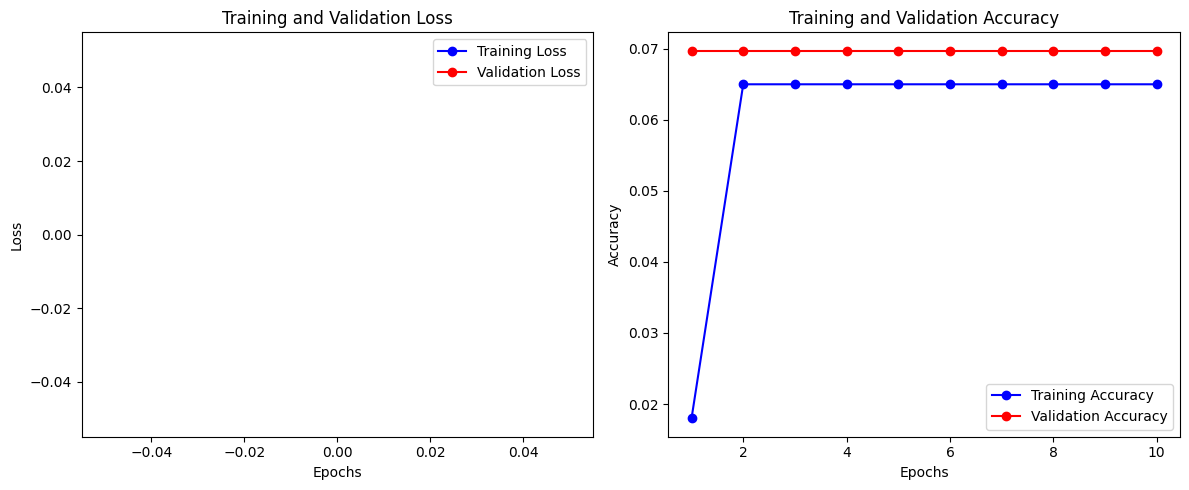

In [33]:
history_dict = history.history

# Extract the loss and accuracy for both training and validation sets
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Create count of the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()